
1.   Reed-solomon ec
4.   Decode v3 for test case 15, v4 for 16







In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
!pip install --upgrade reedsolo
import reedsolo as rs

In [ ]:
def check_pattern(cells):
    """
    Check if the mean value of each cell in cells is within a tolerance of the corresponding value in the pattern.
    """
    pattern = [0, 255, 0, 0, 0, 255, 0]  # 1:1:3:1:1 pattern
    tolerance = 100
    results = [abs(int(np.mean(cell)) - pat) <= tolerance for cell, pat in zip(cells, pattern)]
    return all(results)

def rotate_image(image, degrees):
    return np.rot90(image, degrees // 90)

def check_valid_format(og, qr_cells, grid_cells_num, grid_cell_size):
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = (np.median(cell) // 255)
    ecl = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-2:grid_cells_num, 8]]
    mask = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-3:grid_cells_num-6:-1, 8]]
    fec = np.concatenate(([qr_cells_numeric[grid_cells_num-6, 8]], [qr_cells_numeric[grid_cells_num-7, 8]], qr_cells_numeric[8, grid_cells_num-8:grid_cells_num][::-1]))  # Reverse to get from col 20 to col 13
    fec = [int(not(c)) for c in fec]

    ecl_check = [int(not(c)) for c in qr_cells_numeric[8, :2]]
    mask_check = [int(not(c)) for c in qr_cells_numeric[8, 2:5]]
    fec_check = np.concatenate(([qr_cells_numeric[8, 5]], [qr_cells_numeric[8, 7]], qr_cells_numeric[7:9,8][::-1], qr_cells_numeric[0:6,8][::-1]))
    fec_check = [int(not(c)) for c in fec_check]

    print(ecl + mask + fec == ecl_check + mask_check + fec_check)
    if not (ecl + mask + fec == ecl_check + mask_check + fec_check):
        revert = rotate_image(qr_cells, 270)
        return cv2.flip(og, 1).reshape((grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size)).swapaxes(1, 2)
    else:
        return qr_cells

def correct_orientation(og, qr_cells, grid_cells_num, grid_cell_size):
    """
    Correct the orientation of the QR code by checking the patterns in the corners and rotating if necessary.
    """
    # Check patterns in the corners
    bottom_right = qr_cells[grid_cells_num - 4, -7:], qr_cells[-7:, grid_cells_num-4]
    top_right = qr_cells[3, -7:], qr_cells[:7, grid_cells_num-4]
    bottom_left = qr_cells[grid_cells_num-4, :7], qr_cells[-7:, 3]


    # If the bottom right corner does not match the pattern, the QR code is in the correct orientation
    if not any(map(check_pattern, bottom_right)):
        return qr_cells

    # If all corners match the pattern, rotate 180 degrees
    if all(map(check_pattern, top_right + bottom_left)):
        return rotate_image(qr_cells, 180)

    # If the top right and bottom right corners match the pattern, rotate 270 degrees
    if all(map(check_pattern, top_right + bottom_right)):
        rotated = rotate_image(qr_cells, 90)
        return check_valid_format(og, rotated, grid_cells_num, grid_cell_size)


    # If the bottom left and bottom right corners match the pattern, rotate 90 degrees
    if all(map(check_pattern, bottom_left + bottom_right)):
        return rotate_image(qr_cells, 270)

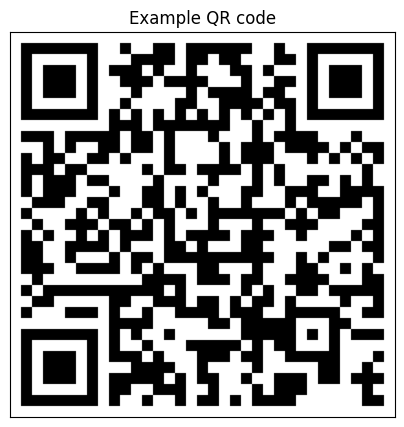

In [ ]:
img = cv2.imread("/content/image16.jpg", cv2.IMREAD_GRAYSCALE)
_, img = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.title('Example QR code')
plt.imshow(img, cmap='gray');

In [ ]:
grid_cells_num = 33
grid_cell_size = 50

# gotta find a new way to get the qr without the quiet zone
start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img):
    for pixel in row:
        if pixel != 255:
            start_row = row_index
            break
    if start_row != -1:
        break

for row_index, row in enumerate(img[::-1]):
    for pixel in row:
        if pixel != 255:
            end_row = img.shape[0] - row_index
            break
    if end_row != -1:
        break

for col_index, col in enumerate(cv2.transpose(img)):
    for pixel in col:
        if pixel != 255:
            start_col = col_index
            break
    if start_col != -1:
        break


for col_index, col in enumerate(cv2.transpose(img)[::-1]):
    for pixel in col:
        if pixel != 255:
            end_col = img.shape[1] - col_index
            break
    if end_col != -1:
        break


top_border = min(start_row, max(start_col, img.shape[1] - end_col))
bottom_border = min(img.shape[0] - end_row, max(start_col, img.shape[1] - end_col))
left_border = min(start_col, max(start_row, img.shape[0] - end_row))
right_border = min(img.shape[1] - end_col, max(start_row, img.shape[0] - end_row))

print(top_border, bottom_border, left_border, right_border)

29 29 29 29


In [ ]:
qr_no_quiet_zone = img[top_border:img.shape[0] - bottom_border, left_border: img.shape[1] - right_border]
qr_no_quiet_zone = cv2.resize(qr_no_quiet_zone, (grid_cells_num * grid_cell_size, grid_cells_num * grid_cell_size), interpolation=cv2.INTER_AREA)

In [ ]:
# ...into grid cells
qr_cells = qr_no_quiet_zone.reshape((
    grid_cells_num,
    grid_cell_size,
    grid_cells_num,
    grid_cell_size,
)).swapaxes(1, 2)
print(qr_cells.shape)

(33, 33, 50, 50)


In [ ]:
corrected_qr = correct_orientation(qr_no_quiet_zone, qr_cells, grid_cells_num, grid_cell_size)

In [ ]:
qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)
for i, row in enumerate(corrected_qr):
    for j, cell in enumerate(row):
        qr_cells_numeric[i, j] = (np.median(cell) // 255)

# qr_cells_numeric = 1 - qr_cells_numeric
print(qr_cells_numeric)

[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]
 [0 1 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 0 0]
 [0 1 1 ... 1 0 1]
 [0 0 0 ... 1 0 0]]


## Information extraction

![Meaning of format information.](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/QR_Format_Information.svg/640px-QR_Format_Information.svg.png)
> *Meaning of format information.*

### Error correction level

In [ ]:
# Level L (Low)         [11]	7%  of data bytes can be restored.
# Level M (Medium)      [10]	15% of data bytes can be restored.
# Level Q (Quartile)    [01]	25% of data bytes can be restored.
# Level H (High)        [00]	30% of data bytes can be restored.

# I generalized the location to suit v3 and v4
# We'll read the ecl from the bottom locator instead
ecl = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-2:grid_cells_num, 8]]
print(ecl)


[1, 1]


### Mask pattern

In [ ]:
# Dictionary of all masks and their equivalent formulae
# MASKS = {
#     "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
#     "001": lambda i, j: (i / 2 + j / 3) % 2 == 0,
#     "010": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
#     "011": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
#     "100": lambda i, j: i % 2 == 0,
#     "101": lambda i, j: (i + j) % 2 == 0,
#     "110": lambda i, j: (i + j) % 3 == 0,
#     "111": lambda i, j: j % 3 == 0,
# }

MASKS = {
    "101": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "100": lambda i, j: (i / 2 + j / 3) % 2 == 0,
    "111": lambda i, j: ((i * j) % 3 + i + j) % 2 == 0,
    "110": lambda i, j: ((i * j) % 3 + i * j) % 2 == 0,
    "001": lambda i, j: i % 2 == 0,
    "000": lambda i, j: (i + j) % 2 == 0,
    "011": lambda i, j: (i + j) % 3 == 0,
    "010": lambda i, j: j % 3 == 0,
}

# We'll read the mask pattern from the three bits before the ecl in col 8
mask = [int(not(c)) for c in qr_cells_numeric[grid_cells_num-3:grid_cells_num-6:-1, 8]]
print(mask)

[0, 0, 1]


### Format error correction

In [ ]:
# We'll get #15, #14 from col 8 since #13 is always black
# We'll also get row 8 from last col to col 13
fec = []
fec.append(qr_cells_numeric[grid_cells_num-6, 8])
fec.append(qr_cells_numeric[grid_cells_num-7, 8])
fec.extend(qr_cells_numeric[8, grid_cells_num-8:grid_cells_num][::-1])
fec = [int(not(c)) for c in fec]
print(fec)


[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


In [ ]:
# So in total we have the following 15 bits of format info from our QR code
print(ecl, mask, fec)

# Added all the formatting info to one list
format_info = [ecl, mask, fec]
format_info = [bit for sub_format in format_info for bit in sub_format]
print(format_info)

[1, 1] [0, 0, 1] [0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]


FOEMAT INFORMATION LOOKUP TABLE

In [ ]:
def calculate_hamming_distance(seq1, seq2):
    return sum(bit1 != bit2 for bit1, bit2 in zip(seq1, seq2))

def is_format_info_valid(format_info):
    valid_format_sequence = [
      [1,0,1,0,1,0,0,0,0,0,1,0,0,1,0], # 00 000
      [1,0,1,0,0,0,1,0,0,1,0,0,1,0,1], # 00 001
      [1,0,1,1,1,1,0,0,1,1,1,1,1,0,0], # 00 010
      [1,0,1,1,0,1,1,0,1,0,0,1,0,1,1], # 00 011
      [1,0,0,0,1,0,1,1,1,1,1,1,0,1,1], # 00 100
      [1,0,0,0,0,0,0,1,1,0,0,1,1,1,0], # 00 101
      [1,0,0,1,1,1,1,1,0,0,1,0,1,1,1], # 00 110
      [1,0,0,1,0,1,0,1,0,1,0,0,0,0,0], # 00 111

      [1,1,1,0,1,1,1,1,1,0,0,0,1,0,0], # 01 000
      [1,1,1,0,0,1,0,1,1,1,1,0,0,1,1], # 01 001
      [1,1,1,1,1,0,1,1,0,1,0,1,0,1,0], # 01 010
      [1,1,1,1,0,0,0,1,0,0,1,1,1,0,1], # 01 011
      [1,1,0,0,1,1,0,0,0,1,0,1,1,1,1], # 01 100
      [1,1,0,0,0,1,1,0,0,0,1,1,0,0,0], # 01 101
      [1,1,0,1,1,0,0,0,1,0,0,0,0,0,1], # 01 110
      [1,1,0,1,0,0,1,0,1,1,1,0,1,1,0], # 01 111

      [0,0,1,0,1,1,0,1,0,0,0,1,0,0,1], # 10 000
      [0,0,1,0,0,1,1,1,0,1,1,1,1,1,0], # 10 001
      [0,0,1,1,1,0,0,1,1,1,0,0,1,1,1], # 10 010
      [0,0,1,1,0,0,1,1,1,0,1,0,0,0,0], # 10 011
      [0,0,0,0,1,1,1,0,1,1,0,0,0,1,0], # 10 100
      [0,0,0,0,0,1,0,0,1,0,1,0,1,0,1], # 10 101
      [0,0,0,1,1,0,1,0,0,0,0,1,1,0,0], # 10 110
      [0,0,0,1,0,0,0,0,0,1,1,1,0,1,1], # 10 111

      [0,1,1,0,1,0,1,0,1,0,1,1,1,1,1], # 11 000
      [0,1,1,0,0,0,0,0,1,1,0,1,0,0,0], # 11 001
      [0,1,1,1,1,1,1,0,0,1,1,0,0,0,1], # 11 010
      [0,1,1,1,0,1,0,0,0,0,0,0,1,1,0], # 11 011
      [0,1,0,0,1,0,0,1,0,1,1,0,1,0,0], # 11 100
      [0,1,0,0,0,0,1,1,0,0,0,0,0,1,1], # 11 101
      [0,1,0,1,1,1,0,1,1,0,1,1,0,1,0], # 11 110
      [0,1,0,1,0,1,1,1,1,1,0,1,1,0,1]  # 11 111
    ]

    # Initialize min_distance with a large number and min_seq with None
    min_distance = float('inf')
    min_seq = None

    for seq in valid_format_sequence:
        # Calculate the hamming distance between format_info and seq
        distance = calculate_hamming_distance(format_info, seq)

        # If the distance is 0, then we have found an exact match
        if distance == 0:
            return seq

        # If the distance is less than min_distance, update min_distance and min_seq
        if distance < min_distance:
            min_distance = distance
            min_seq = seq

    # If no exact match was found, return the sequence with the minimum hamming distance
    format_info = min_seq
    return format_info


In [ ]:
print(is_format_info_valid(format_info))

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


In [ ]:
ecl = format_info[:2]
mask = format_info[2:5]
fec = format_info[5:]

# However..... You need to XOR that with the "format mask": 101010000010010
ecl[0] ^= 1
mask[0] ^= 1
mask[2] ^= 1
fec[5] ^= 1
fec[8] ^= 1

# And now we print...
print(ecl, mask, fec)
mask_str = ''.join([str(c) for c in mask])

[0, 1] [1, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]


In [ ]:
UP, UP_ENC, DOWN, CW, CCW, UP_IRR, DOWN_IRR, CCW_IRR, UP_CORNER, DOWN_CORNER, UP_SKIP_TIM, DOWN_SKIP_TIM,\
DOWN_SKIP_ALIGN, UP_ALIGN, CCW_SKIP_TIM, UP_SKIP_FORMAT  = range(16)
def apply_mask(data_start_i, data_start_j, direction):
    '''
    data_start_i/j represent the first cell's coords in its respective direction
    direction is the masking direction, up(-enc)/down/clockwise/anti-clockwise
    '''
    print(f"Applying mask with start indices: {data_start_i}, {data_start_j}, direction: {direction}")
    result = []
    row_offsets = []
    col_offsets = []
    if (direction in [UP, UP_ENC]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == DOWN):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    #----------------New Directions------------------
    if (direction == UP_IRR):
        row_offsets = [0, -1, -1, -2, -2, -3, -3, -4]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_IRR):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  4]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == CCW_IRR):
        row_offsets = [0,  0, -1, -1, -2, -2, -2, -2]
        col_offsets = [0, -1,  0, -1,  0, -1, -2, -3]
    if (direction == UP_CORNER):
        row_offsets = [0, -1, -1, -2, -3, -3, -3, -3]
        col_offsets = [0,  1,  0,  1,  0,  1,  0, -1]
    if (direction == DOWN_CORNER):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  3]
        col_offsets = [0,  1, -1,  1, -1,  1,  0, -1]
    if (direction == UP_SKIP_TIM):
        row_offsets = [0, -1, -1, -3, -3, -4, -4, -5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_SKIP_TIM):
        row_offsets = [0,  1,  1,  2,  2,  4,  4,  5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  1]
    if (direction == DOWN_SKIP_ALIGN):
        row_offsets = [0,  0,  1,  1,  6,  6,  7,  7]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == UP_ALIGN):
        row_offsets = [0,  0, -1, -1, -2, -3, -4, -5]
        col_offsets = [0, -1,  0, -1, -1, -1, -1, -1]
    if (direction == CCW_SKIP_TIM):
        row_offsets = [0, -1, -1, -2, -2, -3, -3, -3]
        col_offsets = [0,  1,  0,  1,  0,  1,  0, -2]
    if (direction == UP_SKIP_FORMAT):
        row_offsets = [0,  1,  1,  2,  2,  3,  3,  -5]
        col_offsets = [0,  1,  0,  1,  0,  1,  0,  -1]

    for i, j in zip(row_offsets, col_offsets):
        cell = qr_cells_numeric[data_start_i+i, data_start_j+j]
        result.append(int(cell if MASKS[mask_str](data_start_i+i, data_start_j+j) else not cell))
        print(f"Cell bit: {cell}, Mask_bit: {MASKS[mask_str](data_start_i+i, data_start_j+j)}, Mask: {mask_str}")
    print(f"Result: {result}")
    return result[:4] if direction == UP_ENC else result



### Data length

In [ ]:
v1_data_starting_indices = [
    [grid_cells_num-1, grid_cells_num-1, UP_ENC],
    [grid_cells_num-3, grid_cells_num-1, UP],
    [grid_cells_num-7,  grid_cells_num-1,  UP],
    [grid_cells_num-11, grid_cells_num-1,  CCW],
    [grid_cells_num-10, grid_cells_num-3,  DOWN],
    [grid_cells_num-6,  grid_cells_num-3,  DOWN],
    [grid_cells_num-2,  grid_cells_num-3,  CW],
    [grid_cells_num-3,  grid_cells_num-5,  UP],
    [grid_cells_num-7,  grid_cells_num-5,  UP],
    [grid_cells_num-11, grid_cells_num-5,  CCW],
    [grid_cells_num-10, grid_cells_num-7,  DOWN],
    [grid_cells_num-6,  grid_cells_num-7,  DOWN],
    [grid_cells_num-2,  grid_cells_num-7,  CW],
    [grid_cells_num-3,  grid_cells_num-9,  UP],
    [grid_cells_num-7,  grid_cells_num-9,  UP],
    [grid_cells_num-11, grid_cells_num-9,  UP],
    [grid_cells_num-16, grid_cells_num-9,  UP],
    [grid_cells_num-20, grid_cells_num-9,  CCW],
    [grid_cells_num-19, grid_cells_num-11, DOWN],
    [grid_cells_num-14, grid_cells_num-11, DOWN],  # End of message (Terminator)
    [grid_cells_num-12, grid_cells_num-11, DOWN],  # E1
    [grid_cells_num-8,  grid_cells_num-11, DOWN],  # E2
    [grid_cells_num-4,  grid_cells_num-11, DOWN],  # E3
    [grid_cells_num-9,  grid_cells_num-13, UP],    # E4
    [grid_cells_num-12, grid_cells_num-16, DOWN],  # E5
    [grid_cells_num-9,  grid_cells_num-18, UP],    # E6
    [grid_cells_num-12, grid_cells_num-20, DOWN],  # E7
]

v3_data_starting_indices = []
v4_data_starting_indices = []

Alphanumeric Mode Decoding

In [ ]:
ALPHANUMERIC_TABLE = {

    0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
    5: '5', 6: '6', 7: '7', 8: '8', 9: '9',

    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E',
    15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O',
    25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y',
    35: 'Z',

    36: ' ', 37: '$', 38: '%', 39: '*',
    40: '+', 41: '-', 42: '.', 43: '/', 44: ':'
}

def bin_to_alphanum(bits):

    num = int(bits, 2)

    # This part is similar to saying that 78 = 7 * 10 + 8
    # Originally if we're encoding alpahnumeric characters for example TH (T:29, H:17)
    # We would get the binary string by converting 29 * 45 + 17 to binary

    first_num = num // 45
    first_char = ALPHANUMERIC_TABLE[first_num]

    second_num = num % 45
    second_char = ALPHANUMERIC_TABLE[second_num]

    return first_char + second_char

def decode_alphanumeric_v1():
    ans = ''
    data_string = ''
    for a, b, d in v1_data_starting_indices:
        bits = apply_mask(a, b, d)
        # Convert list of bits to string and concatenate to data_string
        data_string += ''.join([str(bit) for bit in bits])

    print(f"data_string: {data_string}")

    # Exclude the first 4 bits of the encoding type
    data_string = data_string[4:]
    print(f"data_string_no_enc: {data_string}")
    # The length should be read in the next 9 bits
    length = int(data_string[:9], 2)
    #print(f"length: {length}")

    data_string = data_string[9:]
    print(f"data_string_no_len: {data_string}")

    # Process the data 11 bits by 11 bits
    while length > 1:
        chars = bin_to_alphanum(data_string[:11])
        ans += chars
        print(f'{data_string[:11]} = {chars}')
        data_string = data_string[11:]
        length -= 2

    # If the number of characters in the to be decoded string is odd, the last character is represented in 6 bits
    if length == 1:
        last_char = ALPHANUMERIC_TABLE[int(data_string[:6], 2)]
        ans += last_char
        print(f'{data_string[:6]} = {last_char}')

    print(f'\nDecoded string: {ans}')


### Data extraction

In [ ]:
def decode_byte_mode_v1():
    print("Starting decode_byte_mode_v1 function...")
    ecl_lookup = {
      '01': 7,
      '00': 10,
      '11': 13,
      '10': 17
    }
    end_of_word = False
    key = ''.join(map(str, ecl))
    print(f"Key: {key}")
    message_bits = []
    enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)
    length = apply_mask(grid_cells_num-3, grid_cells_num-1, UP)
    print(f"Length: {length}, ECL: {ecl}")
    message_bits.extend(enc)
    message_bits.extend(length)
    extracted_data_no_error_correction = ''
    byte_stream = ''
    for i, (a, b, d) in enumerate(v1_data_starting_indices):  # For each starting index and direction
        if i < 2:  # Skip the first two indices enc, len
            continue
        print(f"Processing index: {i}, Starting indices: {a}, {b}, Direction: {d}")
        bits = apply_mask(a, b, d)  # Extract the bits per the indexed QR code symbol
        bit_string = ''.join([str(bit) for bit in bits])  # Convert to string of bits
        alpha_char = chr(int(bit_string, 2))  # Convert binary to int, then to a char
        if not end_of_word and bit_string[:4] != "0000":
            byte_stream += bit_string
        alpha_char = chr(int(bit_string, 2))

        if bit_string[:4] == "0000" and not end_of_word:  # If the first 4 bits are 0s, this is the END
            print(f'{bit_string[:4]}...         = NULL TERMINATOR (END Symbol, SKIP!)')
            message_bits.extend(bits[:4])  # Append only the four bits
            byte = bytes([int(byte_stream[i:i+8], 2) for i in range(0, len(byte_stream), 8)])
            end_of_word = True
        else:
            # If not the END symbol, append full set of bits
            message_bits.extend(bits)
            extracted_data_no_error_correction += alpha_char
            print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')

    int_length = int(''.join(map(str, length)),2)
    try:
        print(f'\ni.e., the data in the QR code as-is are "{byte.decode("utf-8")}"')
    except:
        print(f'\ni.e., the data in the QR code as-is are "{extracted_data_no_error_correction}"')
    print(f'the ECCs in the QR code "{extracted_data_no_error_correction[int_length+1:]}"')

    # use the reedsolo library to decode the message and correct any errors
    # For every 8 bits in the extracted message, convert to a byte
    extracted_data_bytes = [int("".join(map(str, message_bits[i:i+8])), 2) for i in range(0, len(message_bits), 8)]
    reed_solomon = rs.RSCodec(ecl_lookup[key]) # Create a Reed-Solomon codec object with 7 error correction bytes
    print(f'\nDecoding the message using Reed-Solomon error correction...')
    try:
        decoded_data_bytes = reed_solomon.decode(extracted_data_bytes)  # Decode the message
        reed_solomon.maxerrata(verbose=True)
        print(f'The decoded message is: "{decoded_data_bytes[0].decode(encoding="iso-8859-1")}"')
        data_bits = bin(int.from_bytes(decoded_data_bytes[0], byteorder='big'))[13:-4]
        data_bytes = int(data_bits, 2).to_bytes((len(data_bits)+7)//8, 'big')
        print(f'Data in message = "{data_bytes.decode(encoding="utf-8")}"')
    except rs.ReedSolomonError as e:
        print(f'Error decoding the message: {str(e)}')
        # Extract data without error correction


In [ ]:
enc = apply_mask(grid_cells_num-1, grid_cells_num-1, UP_ENC)

Applying mask with start indices: 32, 32, direction: 1
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Result: [1, 1, 0, 1, 1, 1, 0, 1]


In [ ]:
if version == 1:
  if enc == [0, 0, 1, 0]:
    decode_alphanumeric_v1()
  else:
    decode_byte_mode_v1()
elif version == 3:
  decode_byte_mode_v3()
elif version == 4:
  decode_byte_mode_v4()

Starting decode_byte_mode_v1 function...
Key: 01
Applying mask with start indices: 32, 32, direction: 1
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Result: [1, 1, 0, 1, 1, 1, 0, 1]
Applying mask with start indices: 30, 32, direction: 0
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 0, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Cell bit: 1, Mask_bit: False, Mask: 100
Result: [1, 1, 0, 1, 1, 0, 0, 0]
Length: [1, 1, 0, 1, 1, 0, 0, 0], ECL: [0, 1]
Processing index: 2, Starting indices: 26, 32, Direction: 0
Applying mask with start indi